# Setting

In [1]:
from pf_utils import BacktestManager, DataManager, StaticPortfolio, MomentumPortfolio, AssetEvaluator, metrics

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
metrics2 = [
    'cagr', 'monthly_vol', 'monthly_sharpe',
    'max_drawdown', 'avg_drawdown','avg_drawdown_days', 
]

path_data = 'data'
path_tran = 'transaction'

# Universe

In [3]:
from pf_widgets import w_download, w_close
display(w_download, w_close)

Checkbox(value=False, description='Download', indent=False)

Checkbox(value=False, description='Closed', indent=False)

In [4]:
# universe and file
uv_k200 = ['kospi200', 'kospi200_prices.csv']
uv_etf  = ['etf', 'etfs_all.csv']
uv_irp  = ['fund', 'funds_irp.csv']
uv_hana = ['fund', 'funds_kebhana.csv']

## KOSPI200

In [5]:
k200 = DataManager(
    path = path_data,
    **dict(zip(['universe', 'file'], uv_k200))
)
k200.upload()

200 assets from 2021-01-04 to 2024-08-23 uploaded.
df_prices updated


In [6]:
kw = dict(
    n_years=3, 
    close_today = w_close.value,
    #tickers=k200.df_prices.columns
)
k200.download(**kw) if w_download.value else None

In [7]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

## ETF

In [8]:
etf = DataManager(
    path = path_data,
    **dict(zip(['universe', 'file'], uv_etf)))
etf.upload()

881 assets from 2021-01-04 to 2024-08-23 uploaded.
df_prices updated


In [9]:
kw = dict(
    n_years=3, 
    close_today = w_close.value,
    #tickers=etf.df_prices.columns
)
etf.download(**kw) if w_download.value else None

In [10]:
choice = ['069500', '273130', '148070', '379800', '411060', '284430']
df_etf = etf.df_prices[choice]
assetnames_etf = etf.get_names(tickers=choice)
assetnames_etf

0) 069500: KODEX 200
1) 273130: KODEX 종합채권(AA-이상)액티브
2) 148070: KOSEF 국고채10년
3) 379800: KODEX 미국S&P500TR
4) 411060: ACE KRX금현물
5) 284430: KODEX 200미국채혼합

## IRP - FUNDS
- https://www.kiwoomam.com/fund/KI0202020000M?parentfundcode=8325&fundcode=8335
- https://investments.miraeasset.com/fund/view.do?fundGb=2&fundCd=537380&childFundGb=2&childFundCd=53738P
- https://www.hanwhawm.com/main/finance/fundInfo/FI141_2.cmd?p=500&item_cd=5102896

In [13]:
irp = DataManager(
    upload_type = 'rate',
    path = path_data,
    **dict(zip(['universe', 'file'], uv_irp))
)
irp.upload()
df = irp.check_days_in_year(252)

Estimating price from "data/funds_irp.csv" ...
Max error of 14 conversions: 0.16 %
14 assets from 2017-07-31 to 2024-07-31 uploaded.
df_prices updated


In [15]:
irp.convert_to_daily(True)

REMINDER: data converted to daily (days in year: 365)
Daily metrics in Performance statistics must be meaningless


In [17]:
irp.get_date_range()

,start date,end date
K55223BT1450,2017-07-31,2024-07-31
K55105BS5067,2017-07-31,2024-07-31
K55301BU5479,2017-08-14,2024-06-16
K55210BU2435,2017-08-31,2024-07-31
KR5223AE3357,2017-08-31,2024-07-31
K55365BT3694,2017-08-31,2024-07-31
K55207BU0715,2017-08-31,2024-07-31
K55301BU6139,2017-09-20,2024-07-22
K55301BU5453,2017-09-29,2024-06-16
K55203C53681,2018-04-30,2024-07-31


In [18]:
irp.performance('sharpe', 'year')

,daily_sharpe,monthly_sharpe,yearly_sharpe
K55301BU5479,0.971258,0.926647,0.607931
K55301BU6139,0.99284,0.932816,0.606819
K55365BT3694,0.590866,0.586247,0.512494
K55213C51890,0.711905,0.710794,0.494694
K55223BT1450,0.613672,0.609538,0.447105
K55206C96311,0.727533,0.620327,0.440651
K55210BU2435,0.656462,0.653452,0.43721
K55203C53681,0.512799,0.507063,0.432236
K55206C95800,0.765275,0.63428,0.420561
K55301BU5453,1.002487,0.769008,0.387949


In [19]:
df_irp = irp.df_prices
assetnames_irp = irp.get_names()
assetnames_irp

0) K55301BU6139: 미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e
1) K55206C95800: 키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)
2) K55301BU5453: 미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e
3) K55301BU5479: 미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e
4) K55206C96311: 키움키워드림TDF2045증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)
5) K55210BU2435: 신한마음편한TDF2040증권투자신탁[주식혼합-재간접형](종류C-re)
6) K55213C51890: 한화LIFEPLUSTDF2040증권자투자신탁(혼합-재간접형)C-RPe(퇴직연금)
7) K55223BT1450: KB온국민TDF2040증권투자신탁(주식혼합-재간접형)C-퇴직e
8) K55105BS5067: 삼성한국형TDF2040증권투자신탁H[주식혼합-재간접형]C-Pe
9) KR5223AE3357: kb퇴직연금배당증권자투자신탁(주식)C-E
10) K55365BT3694: kcgi코리아퇴직연금증권자투자신탁(주식)종류C-Pe2
11) K55207BU0715: 교보악사파워인덱스증권자투자신탁1호(주식)C-Pe
12) K55203C53681: 대신KOSPI200인덱스증권자투자신탁(주식-파생형)CPe
13) K55234CJ0997: IBK플레인바닐라EMP증권투자신탁(혼합-재간접형)C-Re

## HANA - FUNDS
- https://dis.kofia.or.kr

In [13]:
hana = DataManager(
    upload_type = 'rate',
    path = path_data,
    **dict(zip(['universe', 'file'], uv_hana))
)
hana.upload()
hana.get_date_range()

Estimating price from "data/funds_kebhana.csv" ...
  error: -0.00 %
  error: 0.01 %
  error: -0.00 %
  error: 0.00 %
4 assets from 2010-01-29 to 2024-07-31 uploaded.
df_prices updated


,start date,end date
KR5101888398,2010-01-29,2024-07-31
KR5370AP9956,2014-04-30,2024-07-31
KR5236AS4826,2014-05-30,2024-07-31
K55306CV9946,2019-10-31,2024-07-31


In [6]:
hana.check_days_in_year(12)

KR5101888398    12.0
KR5236AS4826    12.0
KR5370AP9956    12.0
K55306CV9946    12.0
dtype: float64

In [7]:
hana.convert_to_daily(True)

REMINDER: data converted to daily (days in year: 365)
Daily metrics in Performance statistics must be meaningless


In [8]:
df_hana = hana.df_prices
assetnames_hana = hana.get_names()
assetnames_hana

0) KR5101888398: 한국투자크레딧포커스ESG증권자투자신탁 1(채권)(C-e)
1) KR5236AS4826: 한국밸류10년투자증권투자신탁 1(채권혼합)종류C-E
2) KR5370AP9956: AB글로벌고수익증권투자신탁(채권-재간접형)종류형Ce
3) K55306CV9946: 다올글로벌멀티에셋인컴EMP증권자투자신탁[혼합-재간접형](공)종류Ce

<Axes: >

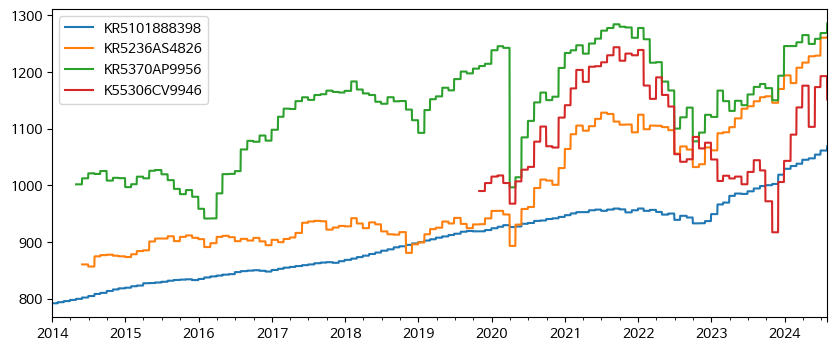

In [9]:
df_hana.loc['2014':].plot(figsize=(10,4))

# Backtest

## KOSPI 200

In [11]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 1, 
    days_in_year = 246,
    asset_names = assetnames_k200
)
bm = BacktestManager(df_k200, **kwargs_bm)

15 assets removed for shorter periods (7.5%)
running self.util_check_days_in_year to check days in a year


In [12]:
lags = dict(lookback=12, lag=5)

In [13]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [14]:
select = 'Momentum'
kwargs_build = dict(
    name=f'KOSPI:{select}', select =select,
    freq='M', weigh = 'ERC',
    n_assets=5, **lags
)
bm.build(**kwargs_build)

In [15]:
select = 'K-ratio'
kwargs_build.update(dict(
    name=f'KOSPI:{select}', select =select,
))
bm.build(**kwargs_build)

In [16]:
select = 'Momentum'
n_assets = 10
kwargs_build = dict(
    name=f'KOSPI:{select}_{n_assets}', select =select,
    freq='M', weigh = 'ERC',
    n_assets=n_assets, **lags
)
bm.build(**kwargs_build)

Backtesting 4 strategies: KODEX200, KOSPI:Momentum, KOSPI:K-ratio, KOSPI:Momentum_10


100%|█████████████████████████████████████████████████████████████████| 4/4 [01:03<00:00, 15.81s/it]

Returning stats


,KOSPI:Momentum,KOSPI:K-ratio,KOSPI:Momentum_10,KODEX200
start,2021-01-03,2021-01-03,2021-01-03,2021-01-03
end,2024-08-23,2024-08-23,2024-08-23,2024-08-23
total_return,4.681265,1.612401,2.168628,0.002629
cagr,0.612504,0.302272,0.373278,0.000722
calmar,2.197839,1.428209,1.339425,0.002597
max_drawdown,-0.278685,-0.211644,-0.278685,-0.278165
avg_drawdown,-0.064276,-0.032612,-0.050644,-0.078234
avg_drawdown_days,17.6,19.309524,25.65625,157.166667
daily_vol,0.399865,0.232031,0.299541,0.156325
daily_sharpe,1.417141,1.27646,1.229812,0.083251


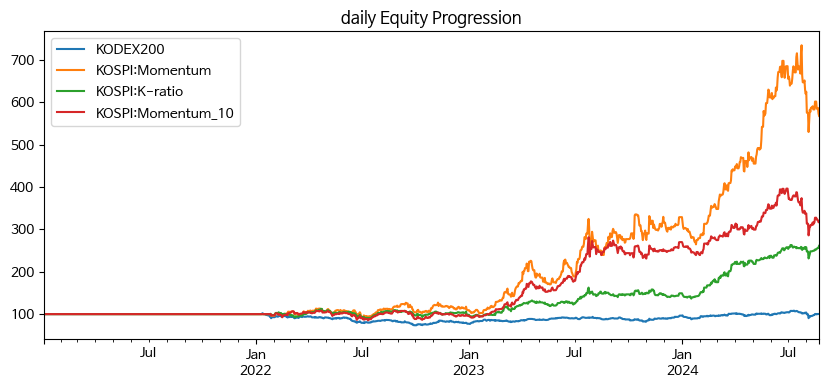

In [17]:
bm.run(figsize=(10,4), stats_sort_by='monthly_sharpe')

In [36]:
df_pf = bm.get_historical()
df_pf = df_pf[['KODEX200','KOSPI:Momentum']]

## ETF

In [38]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 0, 
    days_in_year = 245,
    asset_names = assetnames_etf
)
bm = BacktestManager(df_etf, **kwargs_bm)

period reset: 2021-12-15 ~ 2024-07-18
running self.util_check_days_in_year to check days in a year


In [39]:
lags = dict(lookback=12, lag=5)

In [40]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [41]:
kwargs_build = dict(
    freq = 'Y', select = 'all',
    **lags # added to start backtest on same date with momentum
)

bm.build(name='ETF:Eqaully', weigh='equally', **kwargs_build)
bm.build(name='ETF:ERC', weigh='ERC', **kwargs_build)
bm.build(name='ETF:InvVol', weigh='InvVol', **kwargs_build)

In [42]:
kwargs_build = dict(
    weigh='InvVol',  select = 'all',  **lags
)

bm.build(name='ETF:Eqaully(Q)', freq = 'Q', **kwargs_build)
bm.build(name='ETF:Eqaully(M)', freq = 'M', **kwargs_build)

Backtesting 6 strategies: KODEX200, ETF:Eqaully, ... , ETF:Eqaully(M)


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.79it/s]


Returning stats


,ETF:Eqaully,ETF:ERC,ETF:Eqaully(M),ETF:Eqaully(Q),ETF:InvVol,KODEX200
start,2021-12-14,2021-12-14,2021-12-14,2021-12-14,2021-12-14,2021-12-14
end,2024-07-18,2024-07-18,2024-07-18,2024-07-18,2024-07-18,2024-07-18
total_return,0.270048,0.224691,0.20629,0.202248,0.198584,0.319442
cagr,0.096586,0.081312,0.075017,0.073626,0.072363,0.112842
calmar,2.627234,2.112785,2.004658,1.991795,1.918062,0.895283
max_drawdown,-0.036763,-0.038486,-0.037421,-0.036965,-0.037727,-0.126041
avg_drawdown,-0.007541,-0.007283,-0.006064,-0.00668,-0.006697,-0.02551
avg_drawdown_days,12.216216,16.740741,15.0,16.851852,16.888889,19.192308
daily_vol,0.046106,0.040436,0.038918,0.038857,0.038869,0.125859
daily_sharpe,2.071368,2.000378,1.923199,1.891992,1.860437,0.932876


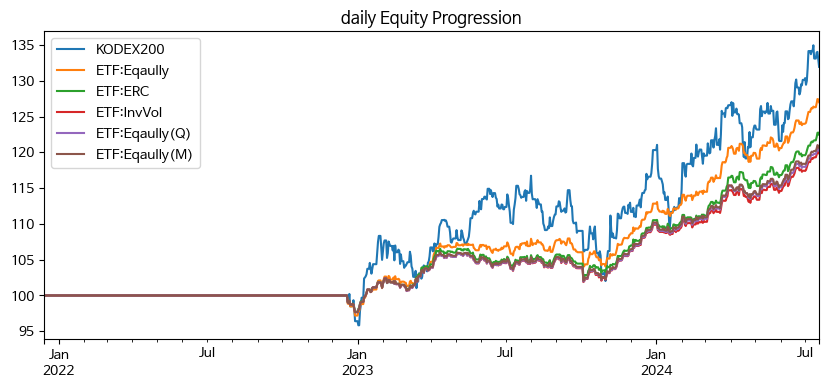

In [43]:
bm.run(figsize=(10,4), stats_sort_by='monthly_sharpe')

In [44]:
df = bm.get_historical()
df_pf = df_pf.join(df[['ETF:Eqaully', 'ETF:ERC']])

NameError: name 'df_pf' is not defined

## IRP

In [20]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 0, 
    days_in_year = 365,
    asset_names = assetnames_irp
)
bm = BacktestManager(df_irp, **kwargs_bm)

period reset: 2019-01-31 ~ 2024-06-16
running self.util_check_days_in_year to check days in a year


In [21]:
lags = dict(lookback=12, lag=5)

In [22]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [26]:
kwargs_build = dict(
    freq = 'Y', select = 'all',
    **lags # added to start backtest on same date with momentum
)

bm.build(name='TDF:Eqaully', weigh='equally', **kwargs_build)
bm.build(name='TDF:ERC', weigh='ERC', **kwargs_build)
bm.build(name='TDF:InvVol', weigh='InvVol', **kwargs_build)
bm.build(name='TDF:MeanVar', weigh='MeanVar', **kwargs_build)

In [27]:
choice = ['K55301BU6139', 'K55206C95800']

kwargs_build.update(dict(
    name='TDF2:Eqaully', select ='all', 
    weigh='Specified',  weights=choice
))
bm.build(**kwargs_build)

Backtesting 6 strategies: KODEX200, TDF:Eqaully, ... , TDF:MeanVar


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.01it/s]

Returning stats


,TDF2:Eqaully,TDF:ERC,TDF:Eqaully,TDF:InvVol,KODEX200,TDF:MeanVar
start,2019-01-30,2019-01-30,2019-01-30,2019-01-30,2019-01-30,2019-01-30
end,2024-06-14,2024-06-14,2024-06-14,2024-06-14,2024-06-14,2024-06-14
total_return,0.319244,0.293361,0.324335,0.282145,0.412397,0.207911
cagr,0.052931,0.049054,0.053686,0.047355,0.06639,0.03579
calmar,0.245474,0.264026,0.262698,0.257763,0.193679,0.188877
max_drawdown,-0.215628,-0.185794,-0.204365,-0.183714,-0.342786,-0.189489
avg_drawdown,-0.018778,-0.011908,-0.012961,-0.011647,-0.052,-0.014691
avg_drawdown_days,40.882353,31.272727,37.72973,34.525,72.380952,44.78125
daily_vol,0.06881,0.06821,0.094874,0.072148,0.186759,0.077941
daily_sharpe,0.801497,0.752605,0.611821,0.692387,0.445341,0.499999


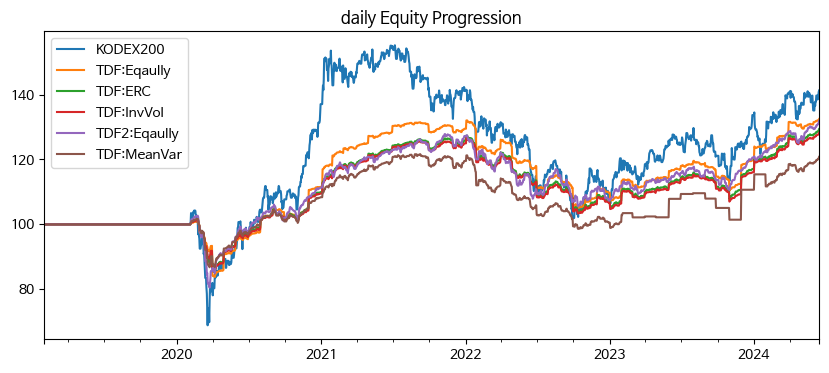

In [28]:
bm.run(figsize=(10,4), stats_sort_by='monthly_sharpe')

In [49]:
df = bm.get_historical()
df_pf = df_pf.join(df['TDF2:Eqaully'])

## HANA

In [10]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 0, 
    days_in_year = 365,
    asset_names = assetnames_hana
)
bm = BacktestManager(df_hana, **kwargs_bm)

period reset: 2019-10-31 ~ 2024-07-31
running self.util_check_days_in_year to check days in a year


In [11]:
lags = dict(lookback=12, lag=5)

In [12]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [13]:
kwargs_build = dict(
    freq = 'Y', select = 'all',
    **lags # added to start backtest on same date with momentum
)

bm.build(name='HANA:Eqaully', weigh='equally', **kwargs_build)
bm.build(name='HANA:ERC', weigh='ERC', **kwargs_build)
bm.build(name='HANA:InvVol', weigh='InvVol', **kwargs_build)

In [14]:
kwargs_build = dict(
    weigh='InvVol',  select = 'all',  **lags
)

bm.build(name='HANA:InvVol(Q)', freq = 'Q', **kwargs_build)
bm.build(name='HANA:InvVol(M)', freq = 'M', **kwargs_build)

Backtesting 6 strategies: KODEX200, HANA:Eqaully, ... , HANA:InvVol(M)


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.16it/s]

Returning stats


,HANA:InvVol,HANA:InvVol(M),HANA:InvVol(Q),HANA:ERC,HANA:Eqaully,KODEX200
start,2019-10-30,2019-10-30,2019-10-30,2019-10-30,2019-10-30,2019-10-30
end,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31
total_return,0.153301,0.128839,0.131496,0.180167,0.155502,0.317262
cagr,0.030463,0.025826,0.026333,0.035468,0.030877,0.05969
calmar,0.531545,0.397336,0.406434,0.434394,0.317349,0.174126
max_drawdown,-0.057311,-0.064998,-0.064791,-0.081649,-0.097296,-0.342796
avg_drawdown,-0.015045,-0.009759,-0.013248,-0.024826,-0.028437,-0.039924
avg_drawdown_days,128.166667,112.125,146.166667,172.0,177.8,87.133333
daily_vol,0.032006,0.032026,0.032686,0.046101,0.049326,0.153677
daily_sharpe,0.973311,0.828929,0.828294,0.7949,0.654115,0.46194


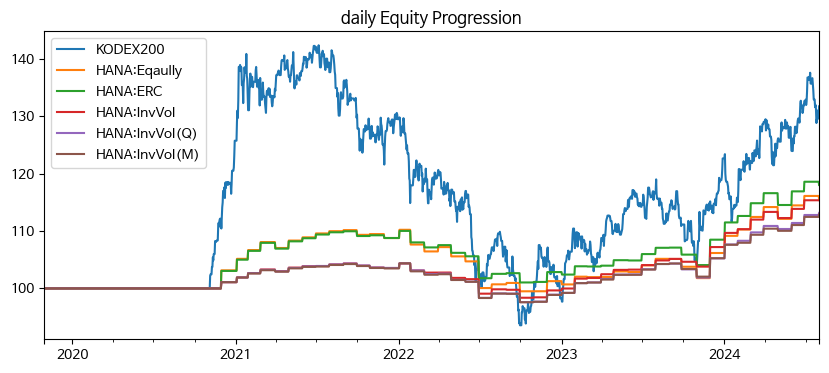

In [15]:
bm.run(figsize=(10,4), stats_sort_by='monthly_sharpe')

In [24]:
df = bm.get_historical()
df_pf = df_pf.join(df['HANA:InvVol'])

NameError: name 'df_pf' is not defined

## Summary

In [58]:
ae = AssetEvaluator(df_pf, 245)

ETF:Eqaully: 244
ETF:ERC: 244
TDF2:Eqaully: 246
HANA:InvVol: 246


In [59]:
ae.get_stats(sort_by='monthly_sharpe', align_period=False)

,ETF:Eqaully,ETF:ERC,KOSPI:Momentum,HANA:InvVol,TDF2:Eqaully,KODEX200
start,2022-12-19,2022-12-19,2022-01-25,2022-01-10,2022-01-10,2022-01-10
end,2024-07-15,2024-07-15,2024-07-15,2024-06-28,2024-06-14,2024-07-15
total_return,0.268406,0.221212,6.076125,0.105528,0.048404,0.073467
cagr,0.163337,0.135605,1.208567,0.041555,0.019678,0.02864
calmar,4.442957,3.523505,4.597925,0.725071,0.120567,0.10294
max_drawdown,-0.036763,-0.038486,-0.262851,-0.057311,-0.16321,-0.278222
avg_drawdown,-0.007653,-0.007471,-0.059227,-0.026509,-0.02669,-0.053124
avg_drawdown_days,12.527778,17.384615,17.604651,214.666667,106.375,150.666667
daily_vol,0.058874,0.051632,0.467956,0.042535,0.068992,0.173314
daily_sharpe,2.673554,2.559844,1.973106,1.001981,0.324167,0.253552


# Transaction

## KOSPI200

In [18]:
kwargs = dict(
    name='KOSPI Momentum',
    file='pf_k200_momentum.csv',
    method_select='Simple', method_weigh='ERC', lookback=12, lag=5,
    path=path_tran,
    days_in_year=246,
    asset_names=assetnames_k200,
)

pf_k200 = MomentumPortfolio(df_k200, **kwargs)

15 assets removed for shorter periods (7.5%)
running self.util_check_days_in_year to check days in a year
Transaction record to 2024-08-22 loaded.
Transaction dates updated for profit/loss on the dates


In [19]:
pf_k200.record

name   price  transaction  net  weight  weight*
date       asset                                                         
2024-07-18 003230         삼양식품  637000            5    5   0.227    0.222
           267260     HD현대일렉트릭  314000            9    9   0.198    0.193
           042700        한미반도체  149000           20   20   0.205    0.211
           000150           두산  200000           13   13   0.189    0.187
           010120  LS ELECTRIC  222000           12   12   0.181    0.187
2024-08-21 267260     HD현대일렉트릭  318000           -1    8   0.192    0.184
           003230         삼양식품  509000            1    6   0.217    0.223
           012450    한화에어로스페이스  282500           10   10   0.206    0.206
           079550       LIG넥스원  193000           14   14   0.199    0.197
           042700        한미반도체  123100            1   21   0.186    0.189
           000150           두산  147600          -13    0   0.000    0.000
           010120  LS ELECTRIC  174400          -12    0   0.000    0.000

Value 11,426,800, Profit -19.8% on 2024-08-23


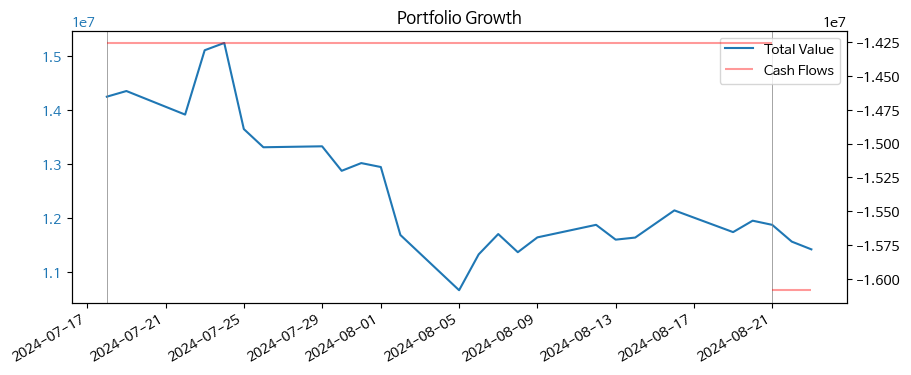

In [20]:
pf_k200.calc_value()

In [ ]:
kwargs = dict(
    #date = '2024-06-15',
    date = None,
    n_assets = 5,
    capital = 0,
    #capital = 15000000,
    save = False
    #save = True
)
pf_k200.transaction_pipeline(**kwargs)

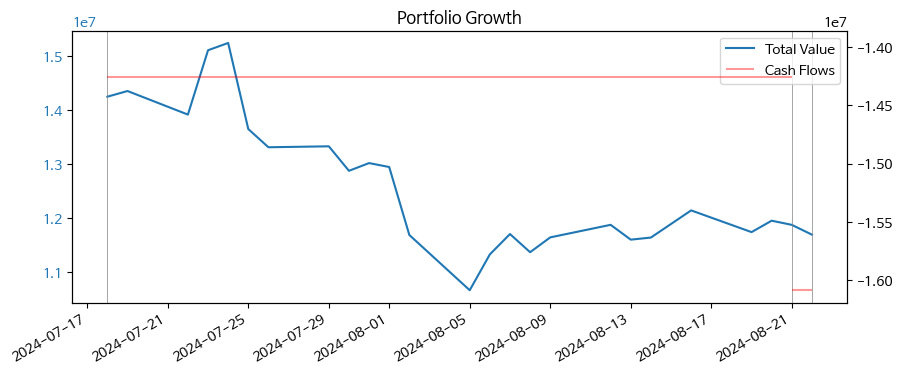

In [23]:
pf_k200.plot()

In [22]:
pf_k200.performance(metrics=metrics)

,KOSPI Momentum
start,2024-07-18
end,2024-08-23
total_return,-0.189344
cagr,-0.88113
calmar,-2.933415
max_drawdown,-0.300377
avg_drawdown,-0.165387
avg_drawdown_days,15.0
daily_vol,0.71251
daily_sharpe,-2.607827


In [16]:
#pf_k200.performance(metrics=metrics2)
df_pf = pf_k200.get_historical()

## ETF

In [23]:
kwargs = dict(
    name='ETF6',
    file='pf_etf_static.csv',
    method_weigh='Equally', lookback=12, lag=5,
    path=path_tran,
    days_in_year=246,
    asset_names=assetnames_etf,
)

pf_etf = StaticPortfolio(df_etf, **kwargs)

period reset: 2021-12-15 ~ 2024-08-23
running self.util_check_days_in_year to check days in a year
Transaction record to 2024-07-18 loaded.
Transaction dates updated for profit/loss on the dates


Value 9,611,322, Profit -2.1% on 2024-08-23


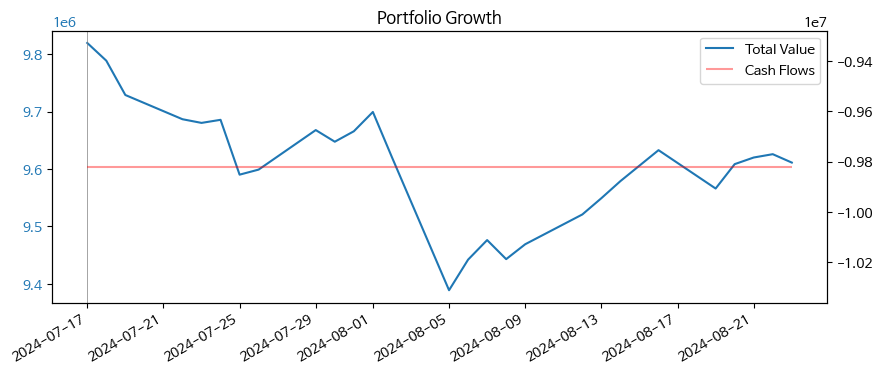

In [24]:
pf_etf.calc_value()

In [25]:
pf_etf.performance(metrics=metrics)

,ETF6
start,2024-07-17
end,2024-08-23
total_return,-0.021244
cagr,-0.191016
calmar,-4.349915
max_drawdown,-0.043912
avg_drawdown,-0.043912
avg_drawdown_days,36.0
daily_vol,0.104601
daily_sharpe,-1.938168


In [26]:
kwargs = dict(
    date = None,
    #date = '2024-07-18',
    capital = 0,
    save = False
    #save = True
)
pf_etf.transaction_pipeline(**kwargs)

6 assets from 2023-08-18 to 2024-08-16 prepared for weight analysis
Weights of assets determined by Equal weights.
Mean absolute error of weights: 1 %
Value 9,635,760, Profit -1.9%
Set save=True to save transaction record


name   price  transaction  net weight  \
date       asset                                                           
2024-07-17 069500             KODEX 200   39085           42   42  0.167   
           273130  KODEX 종합채권(AA-이상)액티브  112895           14   14  0.167   
           148070          KOSEF 국고채10년  114910           14   14  0.167   
           379800      KODEX 미국S&P500TR   17625           94   94  0.167   
           411060            ACE KRX금현물   15715          106  106  0.167   
           284430        KODEX 200미국채혼합   13440          124  124  0.167   
2024-08-23 069500             KODEX 200   36910            2   44  0.167   
           273130  KODEX 종합채권(AA-이상)액티브  113765            0   14  0.167   
           148070          KOSEF 국고채10년  116355            0   14  0.167   
           379800      KODEX 미국S&P500TR   17040            2   96  0.167   
           411060            ACE KRX금현물   15450           -1  105  0.167   
           284430        KODEX 200미국채혼합   13100            0  124  0.167   

                  weight*  
date       asset           
2024-07-17 069500   0.167  
           273130   0.161  
           148070   0.164  
           379800   0.169  
           411060    0.17  
           284430    0.17  
2024-08-23 069500   0.167  
           273130   0.164  
           148070   0.167  
           379800   0.168  
           411060   0.167  
           284430   0.167

In [21]:
df_pf = df_pf.to_frame().join(pf_etf.get_historical(), how='outer')

## IRP

In [28]:
choice = ['K55301BU6139', 'K55206C95800']

In [29]:
kwargs = dict(
    name='TDF2',
    file='pf_tdf_static.csv',
    lookback=12, lag=5,
    path=path_tran,
    days_in_year=365,
    asset_names=assetnames_irp,
)

pf_irp = StaticPortfolio(df_irp[choice], **kwargs)
pf_irp.record

period reset: 2018-07-26 ~ 2024-07-22
running self.util_check_days_in_year to check days in a year
Transaction record to 2024-06-19 loaded.
Transaction dates updated for profit/loss on the dates


name  price  \
date       asset                                                            
2024-06-18 K55301BU6139            미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e   1595   
           K55206C95800  키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)   1367   

                         transaction   net  weight  weight*  
date       asset                                             
2024-06-18 K55301BU6139         3132  3132     0.5      0.5  
           K55206C95800         3657  3657     0.5      0.5

Value 10,084,466, Profit 0.9%


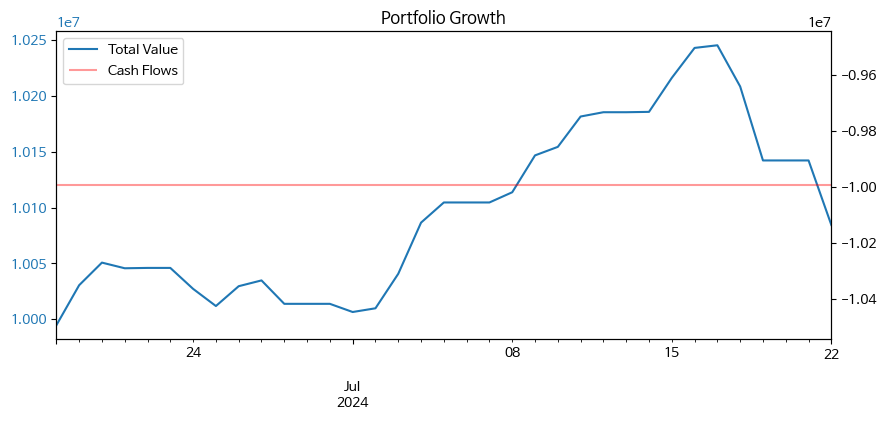

In [30]:
pf_irp.calc_value()

In [31]:
kwargs = dict(
    method_weigh = 'Equally', 
    #date = '2024-06-19',
    capital=0,
    save = False
)
pf_irp.transaction_pipeline(**kwargs)

2 assets from 2023-07-17 to 2024-07-17 prepared for weight analysis
Weights of assets determined by Equal weights.
Mean absolute error of weights: 0 %
Value 10,048,482, Profit 0.5%
Set save=True to save transaction record


name  price  \
date       asset                                                            
2024-06-18 K55301BU6139            미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e   1595   
           K55206C95800  키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)   1367   
2024-07-22 K55301BU6139            미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e   1590   
           K55206C95800  키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)   1386   

                         transaction   net weight weight*  
date       asset                                           
2024-06-18 K55301BU6139         3132  3132    0.5     0.5  
           K55206C95800         3657  3657    0.5     0.5  
2024-07-22 K55301BU6139            9  3141  0.500   0.500  
           K55206C95800          -52  3605  0.500   0.500

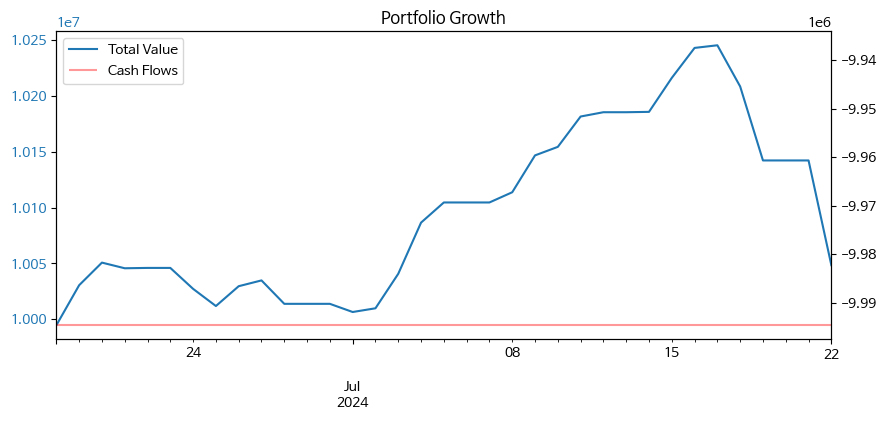

In [32]:
pf_irp.plot()

In [33]:
pf_irp.performance(metrics=metrics)

,TDF2
start,2024-06-18
end,2024-07-22
total_return,0.005385
cagr,0.059393
calmar,3.090541
max_drawdown,-0.019218
avg_drawdown,-0.011809
avg_drawdown_days,8.5
daily_vol,0.042799
daily_sharpe,0.950972


In [34]:
df_pf = df_pf.join(pf_irp.get_historical(), how='outer')
df_pf.tail()

,KOSPI Momentum,ETF6,TDF2
2024-07-18,NaN,9788950.0,1.020846e+07
2024-07-19,14255000.0,9729050.0,1.014225e+07
2024-07-20,NaN,NaN,1.014225e+07
2024-07-21,NaN,NaN,1.014225e+07
2024-07-22,13880500.0,9717710.0,1.004848e+07


## HANA

In [16]:
kwargs = dict(
    name='HANA4',
    file='pf_hana_static.csv',
    method_weigh='InvVol', lookback=12, lag=5,
    path=path_tran,
    days_in_year=365,
    asset_names=assetnames_hana,
)

pf_hana = StaticPortfolio(df_hana, **kwargs)

period reset: 2019-10-31 ~ 2024-07-31
running self.util_check_days_in_year to check days in a year
REMINDER: make sure this is 1st transaction as no records provided


In [17]:
pf_hana.calc_value()

ERROR: No transaction record


In [18]:
kwargs = dict(
    date = None,
    #date = '2024-01-01',
    capital = 10000000,
    #save = False
    save = True
)
pf_hana.transaction_pipeline(**kwargs)

4 assets from 2023-07-26 to 2024-07-26 prepared for weight analysis
Weights of assets determined by Inv.Vol.
Mean absolute error of weights: 0 %
Value 9,991,314, Profit 0.0%
All transactions saved to pf_hana_static_240731.csv


name  price  \
date       asset                                                        
2024-07-31 KR5101888398        한국투자크레딧포커스ESG증권자투자신탁 1(채권)(C-e)   1068   
           KR5236AS4826           한국밸류10년투자증권투자신탁 1(채권혼합)종류C-E   1260   
           KR5370AP9956           AB글로벌고수익증권투자신탁(채권-재간접형)종류형Ce   1285   
           K55306CV9946  다올글로벌멀티에셋인컴EMP증권자투자신탁[혼합-재간접형](공)종류Ce   1151   

                         transaction   net weight weight*  
date       asset                                           
2024-07-31 KR5101888398         4699  4699  0.502   0.502  
           KR5236AS4826         1920  1920  0.242   0.242  
           KR5370AP9956         1448  1448  0.186   0.186  
           K55306CV9946          602   602  0.069   0.069

In [40]:
#pf_hana.df_rec.set_index('name', append=True).apply(lambda x: x.price * x.transaction, axis=1).round(-4)
pf_hana.df_rec.set_index('name', append=True).weight.astype(float).mul(10000000).sum()

9990000.0

In [19]:
pf_hana.plot()

ERROR: need more data to plot


In [39]:
pf_hana.performance(metrics=metrics)

ERROR: Need more data to measure


In [41]:
df_pf = df_pf.join(pf_hana.get_historical(), how='outer')

## Summary

In [42]:
ae = AssetEvaluator(df_pf, 242)
ae.get_stats(sort_by='monthly_sharpe', align_period=False)

KOSPI Momentum: 0
ETF6: 0
TDF2: 0
HANA4: 0


,KOSPI Momentum,ETF6,TDF2,HANA4
start,2024-07-19,2024-07-17,2024-06-18,2024-06-28
end,2024-07-22,2024-07-22,2024-07-22,2024-06-28
total_return,-0.026271,-0.01041,0.005385,NaN
cagr,-0.960888,-0.534419,0.059393,NaN
calmar,-36.575313,-51.334876,3.090541,NaN
max_drawdown,-0.026271,-0.01041,-0.019218,NaN
avg_drawdown,-0.026271,-0.01041,-0.011809,NaN
avg_drawdown_days,0.0,4.0,8.5,NaN
daily_vol,NaN,0.03957,0.042799,NaN
daily_sharpe,NaN,-22.163551,0.950972,NaN


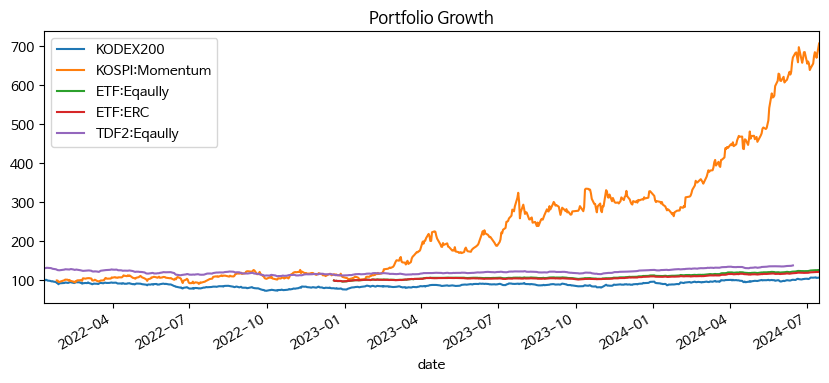

In [34]:
_ = ae.plot_historical()